For today's lab work, we are going to try and improve the accuracy of our  Stochastic Gradient Descent (SGD) Classifier by adding shifted images to our training set.

This should help increase the amount of varied data we have for training our model and in turn improve our accuracy.

So, let's get started!

## 1. Load Data

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_openml('mnist_784', version=1)
type(mnist)

sklearn.utils.Bunch

In [3]:
X, y = mnist["data"], mnist["target"]

type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

Note that the label is a string. We prefer numbers, so let’s cast y to integers:

In [7]:
y = y.astype(np.uint8)

Let us check for missing values:

In [8]:
X.isnull().sum().sum() 

0

In [9]:
# or 
X.isnull().any().any()

False

There are no missing values.

## 2. Data Preparation

There are no categorical variables and no missing values. Since the range of each row, that is, of each image ranges between 0 and 255, there are also no outliers. Thus, the only thing left is to split the data into training and testing.

The MNIST dataset is actually already split into a training set (the first 60.000 images) and a test set (the last 10,000 images):

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training
instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

Remark: Shuffling may be a bad idea in some contexts — for example, if you are working on time series data, that is, data is time dependent. 

## 3. Expand Training Data

Let's rewrite our function to shift images from our group session and shift all the images in our training set by 1 pixel.

We would add these new images back to the training set before retraining our model.

In [11]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(input=image, shift=[dy, dx], cval=0, mode="constant")
    
    return shifted_image.reshape([-1])

Now let's use this function to add our images to our training set.

In [12]:
X_train_expanded = [image for image in X_train.values]
y_train_expanded = [image for image in y_train.values]

In [13]:
len(X_train_expanded), len(y_train_expanded)

(60000, 60000)

In [14]:
shift_patterns = [(-1, 0), (1, 0), (0, -1), (0, 1)]

for pattern in shift_patterns:
    for image in range(len(X_train)):
        shifted_image = shift_image(X_train.values[image], pattern[0], pattern[1])
        X_train_expanded.append(shifted_image)
        y_train_expanded.append(y_train.values[image])

In [15]:
len(X_train_expanded), len(y_train_expanded)

(300000, 300000)

In [16]:
X_train_expanded, y_train_expanded = np.array(X_train_expanded), np.array(y_train_expanded)

We have successfully added 4 new sets of shifted images to our training set with their respective labels.

Now let's go on and train our model using this data.

## 4. Modelling



In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(X_train_expanded, y_train_expanded)

SGDClassifier(random_state=42)

Let's test the model on one value from our test set.

In [18]:
sgd_clf.predict([X_test.iloc[0, :].values])

array([7], dtype=uint8)

In [19]:
y_test.iloc[0]

7


Now of course you want to evaluate the classifier. As usual, you want to use crossvalidation. Let’s evaluate the SGDClassifier’s accuracy using the cross_val_score() function:

In [20]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train_expanded, y_train_expanded, cv=3, scoring="accuracy")

array([0.81606, 0.79461, 0.78876])

Let's scale our inputs and see if there would be an improvement to our models performance.

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_expanded.astype(np.float64))

In [22]:
cross_val_score(sgd_clf, X_train_scaled, y_train_expanded, cv=3, scoring="accuracy")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([0.85094, 0.79113, 0.7896 ])

Scaling the inputs has increased the average of the cross validation accuracy by approximately 0.02

Now let's take a look at our confusion matrix to see the models performance against the various classes of digits we have.

In [24]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train_expanded, cv=3)
conf_mx = confusion_matrix(y_train_expanded, y_train_pred)
conf_mx

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([[25424,     0,   141,    57,    55,   391,   141,    22,  3371,
           13],
       [    8, 28371,   149,   446,    32,   416,    50,   146,  4040,
           52],
       [  104,   123, 23307,   381,   401,   350,   546,   256,  4266,
           56],
       [  125,   114,   505, 23081,    15,  1543,    63,   234,  4273,
          702],
       [   35,    86,   186,    77, 23441,   264,   114,    67,  3808,
         1132],
       [  188,    63,   175,  1074,   368, 20496,   500,    82,  3539,
          620],
       [  195,   148,   527,    90,   197,   986, 24414,    16,  3009,
            8],
       [   90,    93,   307,   125,   255,   181,    12, 25578,  2895,
         1789],
       [  111,   328,   179,   404,    25,   942,   102,    50, 26592,
          522],
       [   79,   187,    86,   434,   811,   540,     5,   925,  4215,
        22463]])

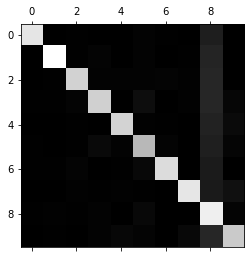

In [25]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks fairly good. Most of the white colours are on the main diagonal, which means that they were classified correctly.

In [26]:
from sklearn.metrics import classification_report

target_names = ['class 0','class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report(y_train_expanded, y_train_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.96      0.86      0.91     29615
     class 1       0.96      0.84      0.90     33710
     class 2       0.91      0.78      0.84     29790
     class 3       0.88      0.75      0.81     30655
     class 4       0.92      0.80      0.86     29210
     class 5       0.79      0.76      0.77     27105
     class 6       0.94      0.83      0.88     29590
     class 7       0.93      0.82      0.87     31325
     class 8       0.44      0.91      0.60     29255
     class 9       0.82      0.76      0.79     29745

    accuracy                           0.81    300000
   macro avg       0.86      0.81      0.82    300000
weighted avg       0.86      0.81      0.82    300000



## 5. Evaluation

The task you were asked is to train a model that predicts the classes, that is, the digits from 0 to 9. In a real world scenario, you would train multiple models, take the best and fine-tune it. We did not fine-tune any model, due to the amount of time we spent on the performance measures of a classification problem. Thus, we pretend that the trained SGD model is our final model for this lab.

You can try other classification models and compare against this model. 

You can also fine-tune to get a more acurate model.

In [27]:
# scale test set
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

# make predictions for the test set
y_test_pred = cross_val_predict(sgd_clf, X_test_scaled, y_test, cv=3)

# evaluate
print(classification_report(y_test, y_test_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      0.95      0.95       980
     class 1       0.97      0.94      0.95      1135
     class 2       0.88      0.86      0.87      1032
     class 3       0.90      0.86      0.88      1010
     class 4       0.88      0.88      0.88       982
     class 5       0.82      0.82      0.82       892
     class 6       0.93      0.91      0.92       958
     class 7       0.89      0.89      0.89      1028
     class 8       0.78      0.88      0.83       974
     class 9       0.85      0.86      0.85      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.89      0.89     10000



From the classification results from our test set our model performed better during testing with an accuracy of 0.89 while we only achieved an accuracy of 0.81 during training. 

## 6. Save The Model

Now that we have thoroughly evaluated our model, we can save it and use for predicting on other data not in our current dataset.

In [28]:
import pickle

filename = 'sgd_clf_multiclass.pkl'
pickle.dump(sgd_clf, open(filename, 'wb'))